In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import xgboost
from sklearn.metrics import mean_absolute_error

In [3]:
X_full=pd.read_csv('train.csv')
print(X_full.shape)


(1460, 81)


In [4]:
X_test_full=pd.read_csv('test.csv')

In [5]:
print(X_test_full.shape)

(1459, 80)


In [7]:
X_test_full.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


<AxesSubplot:>

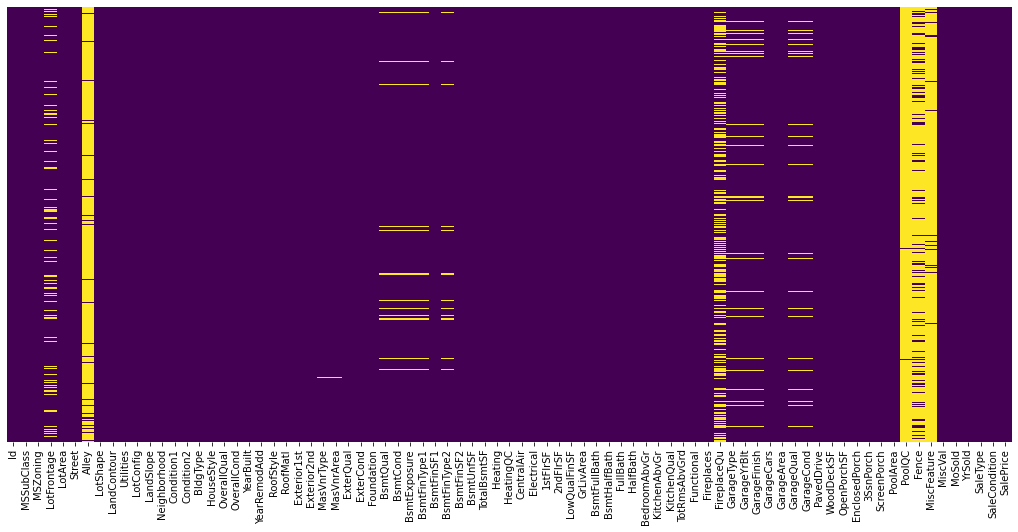

In [6]:
plt.figure(figsize=(18,8))
sns.heatmap(X_full.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
### drop columns with too much NA datas or judged not relevant
X_full.drop(['Alley','GarageYrBlt','PoolQC','Fence','MiscFeature','Id'],axis=1,inplace=True)


<AxesSubplot:>

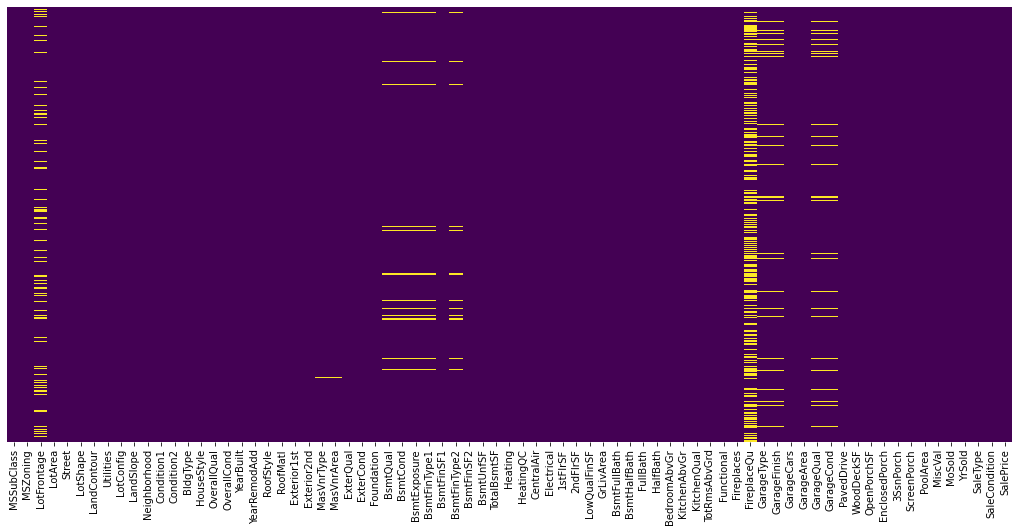

In [8]:
plt.figure(figsize=(18,8))
sns.heatmap(X_full.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [8]:
X_full.dropna(axis=0, subset=['SalePrice'], inplace = True)
y=X_full.SalePrice
X_full.drop(['SalePrice'],axis=1, inplace =True)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=.8, test_size=.2, random_state=0)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() <15 and X_train_full[cname].dtype=='object']
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64','float64']]
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [9]:
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols )
    ])

In [10]:
from xgboost import XGBRegressor

model_1=XGBRegressor(n_estimators=1000, learning_rate= 0.05, n_jobs=-1, random_state=0)

In [11]:
pipe_1=Pipeline(steps=[('peprocessor', preprocessor),
                      ('model', model_1)
                       ])
                      
pipe_1.fit(X_train, y_train)

#early_stopping_rounds=5, , eval_set=[(X_valid, y_valid)], verbose=False  not accepted by sklearn pipeline !!!
preds_test = pipe_1.predict(X_test)
output = pd.DataFrame({'Id': X_test.index,
                      'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)